In [1]:
import tensorflow as tf
import numpy as np
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [2]:
lr = 5e-4
epoch = 50
batch_size = 128
drop_rate = 0.1
la = 1e-5
activation = tf.nn.relu
squashing = tf.nn.sigmoid

In [3]:
import os
LOG_DIR = "./log"
METAGRAPH_DIR = "./out"
PLOTS_DIR = "./png"
for DIR in (LOG_DIR, METAGRAPH_DIR, PLOTS_DIR):
    try:
        os.mkdir(DIR)
    except(FileExistsError):
        pass

In [4]:
import tensorflow as tf
import numpy as np
import copy
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape((-1, 784)), x_test.reshape((-1, 784))
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [5]:
initializer_b = tf.keras.initializers.zeros()
initializer_w = tf.keras.initializers.VarianceScaling(mode='fan_avg')

$$\begin{array}{cccccccccccccccccccccccccccc}
\mbox{Encoding}\\\\
x&\stackrel{\varphi(xw_1+b_1)}{\Rightarrow}&
x_1&\stackrel{\varphi(x_1w_2+b_2)}{\Rightarrow}&
x_2&\stackrel{\varphi(x_2w_3^\mu+b_3^\mu)}{\Rightarrow}&
\mu\\
&\stackrel{\mbox{dropout}}{\Rightarrow}&
x_1&\stackrel{\mbox{dropout}}{\Rightarrow}&
x_2&\stackrel{\varphi(x_2w_3^{\log\sigma^2}+b_3^{\log\sigma^2})}{\Rightarrow}&
\log\sigma^2\\
&&&&&\stackrel{\mu+e^{\frac{1}{2}\log\sigma^2}N(0,1^2)}{\Rightarrow}&
z\\
(?, 784)&&(?, 500)&&(?, 500)&&(?, 2)\\ 
\end{array}$$
$$$$
$$\begin{array}{cccccccccccccccccccccccccccc}
\mbox{Decoding}\\\\
z&\stackrel{\varphi(zw_4+b_4)}{\Rightarrow}&
x_4&\stackrel{\varphi(x_4w_5+b_5)}{\Rightarrow}&
x_5&\stackrel{x_5w_6+b_6}{\Rightarrow}&
\mbox{logits}\\
&\stackrel{\mbox{dropout}}{\Rightarrow}&
x_4&\stackrel{\mbox{dropout}}{\Rightarrow}&
x_5&\stackrel{\sigma(\mbox{logits})}{\Rightarrow}&
x_{recon}\\
\\
(?, 2)&&(?, 500)&&(?, 500)&&(?, 784)\\ 
\end{array}$$

In [6]:
x = tf.placeholder(tf.float32, (None, 784)) 
dropout_rate = tf.placeholder(tf.float32, shape=[], name='dropout_rate')

In [7]:
w1 = tf.get_variable("w1", [784,500], tf.float32, initializer_w) 
b1 = tf.get_variable("b1", [500,], tf.float32, initializer_b) 
x1 = activation(x@w1+b1) 
x1 = tf.nn.dropout(x1, rate=dropout_rate)

w2 = tf.get_variable("w2", [500, 500], tf.float32, initializer_w) 
b2 = tf.get_variable("b2", [500,], tf.float32, initializer_b) 
x2 = activation(x1@w2+b2) 
x2 = tf.nn.dropout(x2, rate=dropout_rate)

In [8]:
w3_mu = tf.get_variable("w3_mu", [500, 2], tf.float32, initializer_w) 
b3_mu = tf.get_variable("b3_mu", [2,], tf.float32, initializer_b) 
mu = activation(x2@w3_mu+b3_mu) 

w3_log_var = tf.get_variable("w3_log_var", [500, 2], tf.float32, initializer_w) 
b3_log_var = tf.get_variable("b3_log_var", [2,], tf.float32, initializer_b) 
log_var = activation(x2@w3_log_var+b3_log_var) 

z = mu + tf.exp(log_var / 2) * tf.random_normal(shape=tf.shape(mu))

In [9]:
w4 = tf.get_variable("w4", [2, 500], tf.float32, initializer_w) 
b4 = tf.get_variable("b4", [500,], tf.float32, initializer_b)
x4 = activation(z@w4+b4)
x4 = tf.nn.dropout(x4, rate=dropout_rate)

w5 = tf.get_variable("w5", [500, 500], tf.float32, initializer_w) 
b5 = tf.get_variable("b5", [500,], tf.float32, initializer_b)
x5 = activation(x4@w5+b5)
x5 = tf.nn.dropout(x5, rate=dropout_rate)

In [10]:
w6 = tf.get_variable("w6", [500, 784], tf.float32, initializer_w) 
b6 = tf.get_variable("b6", [784,], tf.float32, initializer_b)
logits = x5@w6+b6
x_recon = squashing(logits)

In [11]:
recon = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=x)
recon_loss = tf.reduce_sum(recon, axis=1)
kl = tf.exp(log_var) + mu**2 - 1. - log_var
kl_loss = 0.5 * tf.reduce_sum(kl, axis=1)
l2_loss_w = [tf.nn.l2_loss(var)
             for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
             if "w" in var.name]
l2_loss = la * tf.add_n(l2_loss_w)
loss = tf.reduce_mean(recon_loss + kl_loss + l2_loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
#train = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
variables = tf.trainable_variables()
grads_and_vars = optimizer.compute_gradients(loss, variables)
clipped_grads_and_vars = [(tf.clip_by_value(grad, -5, 5), var) # gradient clipping
                          for grad, var in grads_and_vars]
train = optimizer.apply_gradients(clipped_grads_and_vars)

In [13]:
with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    loss_trace = []

    for i in range(epoch):
        idx = np.arange(x_train.shape[0])
        np.random.shuffle(idx)
        x_epoch = x_train[idx]
        for k in range(x_train.shape[0]//batch_size):
            x_batch = x_epoch[k*batch_size:(k+1)*batch_size]
            feed_dict = {x:x_batch, dropout_rate: drop_rate}
            loss_run, _ = sess.run([loss, train], feed_dict=feed_dict)
            loss_trace.append(loss_run)
    
    feed_dict = {x:x_test[:10], dropout_rate: 0.0}
    x_test_z, x_test_recon = sess.run([z, x_recon], feed_dict=feed_dict)
    
    z_random = np.random.normal(size=(10, 2))
    feed_dict = {z:z_random, dropout_rate: 0.0}
    random_recon = sess.run(x_recon, feed_dict=feed_dict)
    
    x_lattice = np.linspace(-8,8,9) 
    y_lattice = np.linspace(-8,8,9) 
    x_lattice, y_lattice = np.meshgrid(x_lattice, y_lattice)
    x_lattice, y_lattice = x_lattice.reshape((-1,1)), y_lattice.reshape((-1,1))
    z_lattice = np.concatenate([x_lattice, y_lattice], axis=1)
    feed_dict = {z:z_lattice, dropout_rate: 0.0}
    lattice_recon = sess.run(x_recon, feed_dict=feed_dict)

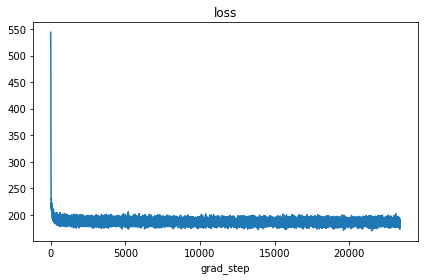

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(loss_trace)
ax.set_title('loss')
ax.set_xlabel('grad_step')
plt.tight_layout()
plt.show()

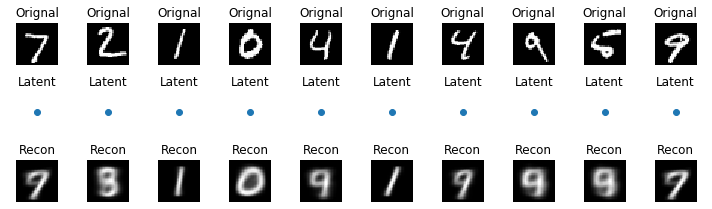

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 10, figsize=(10,3))
for i in range(3):
    for k in range(10):
        if i==0:
            axes[i,k].imshow(x_test[k].reshape((28,28)), cmap=plt.cm.gray)
            axes[i,k].set_title('Orignal')
        elif i==1:
            axes[i,k].scatter(x_test_z[k][0], x_test_z[k][1])
            axes[i,k].set_title('Latent')
        else:
            axes[i,k].imshow(x_test_recon[k].reshape((28,28)), cmap=plt.cm.gray)
            axes[i,k].set_title('Recon')
        axes[i,k].axis('off')
plt.tight_layout()
plt.show()

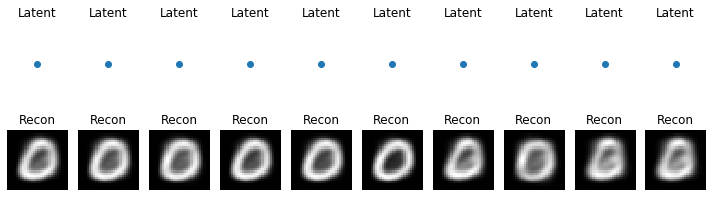

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 10, figsize=(10,3))
for i in range(2):
    for k in range(10):
        if i==0:
            axes[i,k].scatter(x_test_z[k][0], x_test_z[k][1])
            axes[i,k].set_title('Latent')
        else:
            axes[i,k].imshow(random_recon[k].reshape((28,28)), cmap=plt.cm.gray)
            axes[i,k].set_title('Recon')
        axes[i,k].axis('off')
plt.tight_layout()
plt.show()

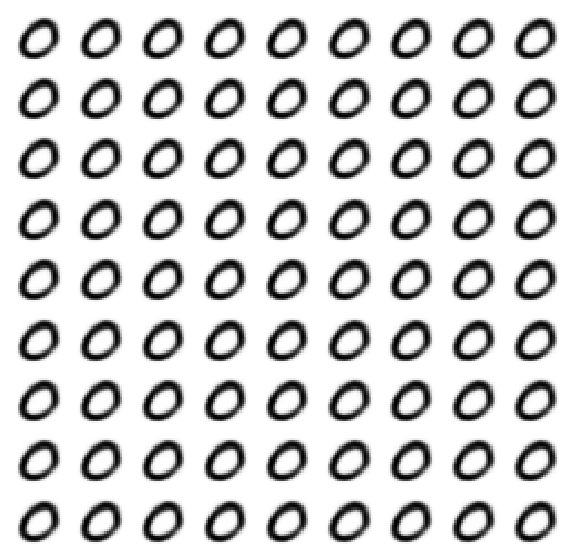

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(9, 9, figsize=(10,10))
for ax in axes.reshape((-1,)):
    ax.imshow(lattice_recon[k].reshape((28,28)), cmap="Greys", aspect="auto")
    ax.axis('off')
plt.subplots_adjust(hspace=0.0, wspace=0.0)
plt.show()